In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from utilities.imports import *

### Borrowing Fast AI's Imagenette

In [3]:
imagenette_path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
imagenette_path

WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160')

In [4]:
#monkey patching LS command
Path.ls = lambda x: list(x.iterdir())
imagenette_path.ls()

[WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train'),
 WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/val')]

In [5]:
path_tench = imagenette_path/'val'/'n01440764'
img_fn = path_tench.ls()[0]
img_fn

WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/val/n01440764/ILSVRC2012_val_00009111.JPEG')

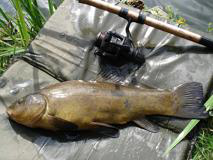

In [6]:
img = PIL.Image.open(img_fn)
img

In [7]:
nump_im = numpy.array(img)
nump_im.shape
#160h, 213w, 3 color channel (RGB)

(160, 213, 3)

In [8]:
image_extensions = list_image_ext()
print(image_extensions) #all extensions on my machine

{'.ppm', '.rgb', '.jpeg', '.pbm', '.gif', '.ief', '.bmp', '.ico', '.tif', '.jpe', '.svg', '.xwd', '.xpm', '.pnm', '.ras', '.jpg', '.tiff', '.xbm', '.pgm', '.png'}


In [9]:
files_t = get_file_names(path_tench)
files = get_file_paths(imagenette_path, files_t, extensions=image_extensions)
files[:3]

[WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/ILSVRC2012_val_00009111.JPEG'),
 WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/ILSVRC2012_val_00009191.JPEG'),
 WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/ILSVRC2012_val_00017472.JPEG')]

In [10]:
get_all_files(path_tench, image_extensions)[:3]

[WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/val/n01440764/ILSVRC2012_val_00009111.JPEG'),
 WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/val/n01440764/ILSVRC2012_val_00009191.JPEG'),
 WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/val/n01440764/ILSVRC2012_val_00017472.JPEG')]

### Defining a class to hold items for the datasets

In [11]:
#composes a list of functions
#order_key -> ordering of applying functions
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(convert_to_list(funcs), key=key): x = f(x, **kwargs)
    return x

class ItemList(ListContainer):
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path,self.tfms = Path(path),tfms

    def __repr__(self): return f'{super().__repr__()}\nPath: {self.path}'
    
    def new(self, items, cls=None):
        if cls is None: cls=self.__class__
        return cls(items, self.path, tfms=self.tfms)
    
    def  get(self, i): return i
    def _get(self, i): return compose(self.get(i), self.tfms)
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res,list): return [self._get(o) for o in res]
        return self._get(res)
    

class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_extensions
        return cls(get_all_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn): return PIL.Image.open(fn)

In [12]:
class Transform():
    _order = 0
    
    
class convert_to_RGB(Transform):
    def __call__(self, item):
        if not isinstance(type(item), type(PIL.Image.Image)):
            raise TypeError('Images must be of type:' + str(PIL.Image.Image))
        return item.convert('RGB')

def make_rgb(item):
    return item.convert('RGB')

In [13]:
item_list = ImageList.from_files(imagenette_path, tfms=make_rgb)

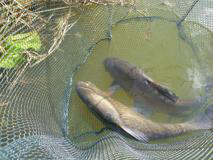

In [14]:
test = convert_to_RGB()
test(item_list[0])
item_list[0]

In [15]:
item_list

ImageList (13394 items)
[WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00000293.JPEG'), WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00002138.JPEG'), WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00003014.JPEG'), WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00006697.JPEG'), WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00007197.JPEG'), WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00009346.JPEG'), WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00009379.JPEG'), WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00009396.JPEG'), WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00010306.JPEG'), WindowsPath('C:/Users

## Adding split functionality

In [16]:
#splits by grandparent directory using the passed in parent directory names
def grandparent_splitter(fn, valid_name='valid', train_name='train'):
    gp = fn.parent.parent.name
    return True if gp==valid_name else False if gp==train_name else None

#splits a list of items by a given function
def split_by_function(items, func):
    mask = [func(o) for o in items]
    # `None` values will be filtered out
    f_itms = [o for o,m in zip(items,mask) if m==False]
    t_itms = [o for o,m in zip(items,mask) if m==True ]
    return f_itms,t_itms

split_itm_lst = partial(grandparent_splitter, valid_name='val')
train,valid = split_by_function(item_list, split_itm_lst)
len(valid), len(train)

(3925, 9469)

In [17]:
class SplitData():
    def __init__(self, train, valid): 
        self.train,self.valid = train,valid
    
    #trys to get the attribute from the training set
    def __getattr__(self,k):
        return getattr(self.train,k)

    #This is needed if we want to pickle SplitData and be able to load it back without recursion errors
    def __setstate__(self,data:Any): 
        self.__dict__.update(data) 
    
    @classmethod
    def split_by_function(cls, itm_lst, func):
        lists = map(itm_lst.new, split_by_function(itm_lst.items, func)) #returns item lists of the same type it was given, uses New ctor
        return cls(*lists)

    def __repr__(self): 
        return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

In [18]:
split_data = SplitData.split_by_function(item_list, split_itm_lst)
split_data

SplitData
Train: ImageList (9469 items)
[WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00000293.JPEG'), WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00002138.JPEG'), WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00003014.JPEG'), WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00006697.JPEG'), WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00007197.JPEG'), WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00009346.JPEG'), WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00009379.JPEG'), WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00009396.JPEG'), WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00010306.JPEG'), Windo

# Labeling

In [19]:
def get_unique_keys(lst, sort=False):
    result = list(OrderedDict.fromkeys(lst).keys()) #get the keys
    if sort is True: result.sort()
    return result

class Processor(): 
    def process(self, items): return items

class CategoryProcessor(Processor):
    def __init__(self): self.vocab=None
    
    def __call__(self, items):
        #The vocab is defined for the training set, so create the vocab
        if self.vocab is None:
            self.vocab = get_unique_keys(items)
            self.otoi  = {v:k for k,v in enumerate(self.vocab)} #reverse mapping 
        return [self.process_one(o) for o in items]
    def process_one(self, item):
        return self.otoi[item]
    
    def deprocess(self, idxs):
        assert self.vocab is not None
        return [self.deprocess_one(idx) for idx in idxs]
    def deprocess_one(self, idx): 
        return self.vocab[idx]

In [20]:
def parent_labeler(fn): return fn.parent.name

def _label_by_func(ds, f, cls=ItemList): return cls([f(o) for o in ds.items], path=ds.path)

#This is a slightly different from what was seen during the lesson,
#   we'll discuss the changes in lesson 11
class LabeledData():
    def process(self, il, proc): return il.new(compose(il.items, proc))

    def __init__(self, x, y, proc_x=None, proc_y=None):
        self.x,self.y = self.process(x, proc_x),self.process(y, proc_y)
        self.proc_x,self.proc_y = proc_x,proc_y
        
    def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n'
    def __getitem__(self,idx): return self.x[idx],self.y[idx]
    def __len__(self): return len(self.x)
    
    def x_obj(self, idx): return self.obj(self.x, idx, self.proc_x)
    def y_obj(self, idx): return self.obj(self.y, idx, self.proc_y)
    
    def obj(self, items, idx, procs):
        isint = isinstance(idx, int) or (isinstance(idx,torch.LongTensor) and not idx.ndim)
        item = items[idx]
        for proc in reversed(listify(procs)):
            item = proc.deproc1(item) if isint else proc.deprocess(item)
        return item

    @classmethod
    def label_by_func(cls, il, f, proc_x=None, proc_y=None):
        return cls(il, _label_by_func(il, f), proc_x=proc_x, proc_y=proc_y)

#returns split data that is labelled
def label_by_func(sd, f, proc_x=None, proc_y=None):
    train = LabeledData.label_by_func(sd.train, f, proc_x=proc_x, proc_y=proc_y)
    valid = LabeledData.label_by_func(sd.valid, f, proc_x=proc_x, proc_y=proc_y)
    return SplitData(train,valid)

In [21]:
labeled_data = label_by_func(split_data, parent_labeler, proc_y=CategoryProcessor())
labeled_data.train.y

ItemList (9469 items)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0...]
Path: C:\Users\Carson\.fastai\data\imagenette2-160

In [22]:
labeled_data

SplitData
Train: LabeledData
x: ImageList (9469 items)
[WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00000293.JPEG'), WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00002138.JPEG'), WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00003014.JPEG'), WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00006697.JPEG'), WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00007197.JPEG'), WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00009346.JPEG'), WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00009379.JPEG'), WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00009396.JPEG'), WindowsPath('C:/Users/Carson/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_0001030

## PIL Objects to Tensors

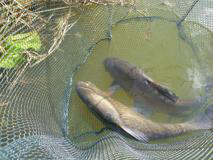

In [24]:
labeled_data.train[0][0]

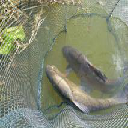

In [26]:
labeled_data.train[0][0].resize((128,128))

### Resize Transform

In [103]:
class ResizedFixed(Transform):
    _order = 10 #ensure it happens after the other transforms
    def __init__(self, size):
            if isinstance(size, int): #make the 2D square dimensions 
                size =(size,size)
            self.size = size
    def __call__(self, item, image_interpolation=PIL.Image.BILINEAR):
        if not isinstance(item, PIL.Image.Image):
            raise TypeError
        return item.resize(self.size, image_interpolation)
        
def to_byte_tensor(item):
    result = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes())) #convert to bytes using PyTorch
    w,h = item.size
    return result.view(h,w,-1).permute(2,0,1) #matrix transform to move Channel (back in PIL) to front (front in Pytorch Tesnsors)
to_byte_tensor._order = 20

def to_float_tensor(item):
    return item.float().div_(255.) #in range [0,1]
to_float_tensor._order=30

### Putting them into action

In [109]:
tfms = [make_rgb, ResizedFixed(128), to_byte_tensor, to_float_tensor]

image_list = ImageList.from_files(imagenette_path, tfms=tfms)
split_data = SplitData.split_by_function(image_list, split_itm_lst)
labled_split_data = label_by_func(split_data, parent_labeler, proc_y=CategoryProcessor())

#### helper function to easily convert a tensor into a viewable image

torch.Size([3, 128, 128])


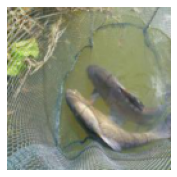

In [105]:
def show_image(im, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(im.permute(1,2,0))
# show_image()
x,y = labled_data.train[0]
print(x.shape)
show_image(x)

# Training with the transformed datasets

Training Data Shape:  torch.Size([64, 3, 128, 128])
Training Data Label:  n03028079


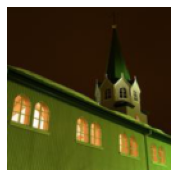

In [140]:
bs = 64
train_dl = torch.utils.data.DataLoader(labled_split_data.train, bs, shuffle= True)
valid_dl = torch.utils.data.DataLoader(labled_split_data.valid, bs*2, shuffle= False)
x, y = next(iter(train_dl))
print("Training Data Shape: ", x.shape)
show_image(x[0])
print("Training Data Label: ", ll.train.proc_y.vocab[y[0]])

## A Setup Example:

In [183]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
tfms = [make_rgb, ResizedFixed(128), to_byte_tensor, to_float_tensor]
cbfs = [partial(AvgStatsCallback,accuracy), CudaCallback]
bs = 64
num_filters = [64,64,128,256]
lr_schedule = combine_schedules([0.3,0.7], [cosine_scheduler(0.1,0.3), cosine_scheduler(0.3,0.05)])

im_lst = ImageList.from_files(path, tfms=tfms)
split_d = SplitData.split_by_function(im_lst, partial(grandparent_splitter, valid_name='val'))
label_l = label_by_func(split_d, parent_labeler, proc_y=CategoryProcessor())
train_dl = torch.utils.data.DataLoader(label_l.train, bs, shuffle= True)
valid_dl = torch.utils.data.DataLoader(label_l.valid, bs*2, shuffle= False)

num_categories = 10
num_channels = 3

In [152]:
#normalize the data using stats from a batch
def normalize_chan(x, mean, std):
    return (x-mean[...,None,None]) / std[...,None,None]
#taking the mean and std over all 3 channels (remember MNIST only had a single channel)
m,s = x.mean((0,2,3)).cuda(),x.std((0,2,3)).cuda()
m,s

_m = tensor([0.47, 0.48, 0.45])
_s = tensor([0.29, 0.28, 0.30])
norm_imagenette = partial(normalize_chan, mean=_m.cuda(), std=_s.cuda()) #normalize anything with imagenette dataset


In [149]:
cbfs.append(partial(IndependentVarBatchTransformCallback, norm_imagenette)) #normalize the dataset using the callback

#### Constructing the Model using: [Bag of Tricks for Image Classification with CNNs](https://arxiv.org/abs/1812.01187)

In [181]:
def prev_pow_2(x): return 2**math.floor(math.log2(x))

def get_cnn_layers(train_dl, valid_dl, nfs,layer, **kwargs):
    def f(ni, nf, stride=2): return layer(ni, nf, 3, stride=stride, **kwargs)
    l1 = num_ch
    l2 = prev_pow_2(l1*3*3)
    layers =  [f(l1  , l2  , stride=1),
               f(l2  , l2*2, stride=2),
               f(l2*2, l2*4, stride=2)]
    nfs = [l2*4] + nfs
    layers += [f(nfs[i], nfs[i+1]) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), Lambda(flatten), 
               nn.Linear(nfs[-1], num_cat)]
    return layers

def get_cnn_model(train_dl, valid_dl, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(train_dl, valid_dl, nfs, layer, **kwargs))

def get_learn_run(nfs, train_dl, valid_dl, lr, layer, cbs=None, opt_func=None, **kwargs):
    model = get_cnn_model(train_dl, valid_dl, nfs, layer, **kwargs)
    init_cnn(model)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [185]:
learn,run = get_learn_run(num_filters, train_dl, valid_dl, 0.2, conv_layer, cbs=cbfs+[
    partial(ParamScheduler, 'lr', lr_schedule)
], num_cat = num_categories,num_ch = num_channels)

TypeError: get_cnn_model() missing 1 required positional argument: 'layer'

### to do, flush out calls to construct model